In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme(style="ticks")

from dotenv import load_dotenv
import os
import glob
import json

# Pilot checks

### Specify paths + load data files

In [2]:
pilot_name = "rn-iii-pilot-2"
to_save_plots = True
data_path = f"./data/for_plots/{pilot_name}"

figures_path = f"./analysis/figures/{pilot_name}"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

scores_df = pd.read_csv(os.path.join(data_path,"scores.csv"),index_col=0)
trials_time = pd.read_csv(os.path.join(data_path,"trials_time.csv"))
sessions_time = pd.read_csv(os.path.join(data_path,"sessions_time.csv"))
post_survey_df = pd.read_csv(os.path.join(data_path,"post_survey_df.csv"))

## Metrics for Alex and Levin
### P_SOCIAL_LEARNING
The chance of a participant to learn the optimal strategy by observing a single optimal demonstration.
(number of participant in pilot b that reach level 4 in demonstration trials) / (number of participants in pilot b * number of demonstration trails per participant)

In [110]:
b = scores_df[ (scores_df['expName']=='rn-iii-pilot-2B') & (scores_df['trialType']=='demonstration') & (scores_df['isAI']==False) ]
print("P_SOCIAL_LEARNING: ", len(b[b['maxLevelReached']==4])/len(b))

P_SOCIAL_LEARNING:  0.15


### P_INDIVIDUAL_LEARNING
The chance of the chance of a participant to learn the optimal strategy by individual learning in a single round
(number of participant in pilot a that reach level 4 in individual trials) / (number of participants in pilot a * number of individual learning trails per participant)

In [111]:
a = scores_df[ (scores_df['expName']=='rn-iii-pilot-2A') & (scores_df['trialType']=='individual') & (scores_df['isAI']==False) ]
print("P_INDIVIDUAL_LEARNING: ", len(a[a['maxLevelReached']==4])/len(a))

P_INDIVIDUAL_LEARNING:  0.17777777777777778


In [112]:
a.groupby(by=['sessionId'])['trialType'].size()

sessionId
63e60e5c86a07638e1044c25    18
63e60e5c86a07638e1044c26    18
63e60e5c86a07638e1044c27    18
63e60e5c86a07638e1044c28    18
63e60e5c86a07638e1044c29    18
63e60e5c86a07638e1044c2a    18
63e60e5c86a07638e1044c2b    18
63e60e5c86a07638e1044c2c    18
63e60e5c86a07638e1044c2d    18
63e60e5c86a07638e1044c2e    18
Name: trialType, dtype: int64

In [113]:
from models.session import Session
from models.network import Network
from models.trial import Trial

data = []
trial_table_columns = ['sessionId', 'generation', 'trialType', 'trialIdx', 'parentSessionId',
                            'parentSession_isAI']
session_isAI_dict = {}
wdir = os.getcwd()
ddir = os.path.join(wdir, 'data')
data_path = glob.glob(os.path.join(ddir, 'raw', 'rn-iii-pilot-2A') + f'/sessions_rn-iii-pilot-2A_*.json')[0]

# Opening JSON file (sessions)
with open(data_path) as json_file:
    sessions = json.load(json_file)

# validate data using pydantic Session model and create list of sessions
sessions_list = [Session(**s) for s in sessions]
for s in sessions_list:
    session_isAI_dict[s.id] = s.ai_player


for s in sessions_list:
    for t in s.trials:
        #print(s.id, t.trial_type)
        # if t.trial_type not in ['social_learning']:
        if t.trial_type not in ['observation', 'repeat', 'try_yourself']:
            data.append((s.id, s.generation, t.trial_type, t.id, None, None))
        else:
            data.append((s.id,
                         s.generation,
                         t.trial_type,  # t.trial_type + '_' + t.social_learning_type,
                         t.id,
                         t.advisor.advisor_id,
                         session_isAI_dict[t.advisor.advisor_id]))

# make dataframe and save it as csv
trial = pd.DataFrame(data, columns=trial_table_columns)
print('PILOT A')
trial.groupby(by=['sessionId'])['trialType'].value_counts()

PILOT A


sessionId                 trialType       
63e60e5c86a07638e1044c25  individual          18
                          instruction          4
                          demonstration        2
                          consent              1
                          debriefing           1
                                              ..
63e60e5c86a07638e1044c2e  consent              1
                          debriefing           1
                          post_survey          1
                          practice             1
                          written_strategy     1
Name: trialType, Length: 80, dtype: int64

### SOLUTION_SIG, SOLUTION_MEAN, SOLUTION_RANDOM_MEAN, SOLUTION_MYOPIC_MEAN and SOLUTION_OPTIMAL_MEAN
Take all human trials from both pilots

In [114]:
c = scores_df[ (scores_df['score'].notnull()) & (scores_df['isAI']==False) & (scores_df['trialType'].isin(['individual','demonstration']))]
print("SOLUTION_SIG: ",c.var()['score'])

SOLUTION_SIG:  238345.62211981564


/var/folders/bf/1wzkxhv923145cbh3xbz51kh0000gr/T/ipykernel_24937/628225127.py:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print("SOLUTION_SIG: ",c.var()['score'])


In [115]:
# bring in myopic and random solutions
random = pd.read_csv('/Users/bonati/Desktop/CHM/reward_networks/solve_networks/df_solutions_random.csv')
random = random[random['step']==8][['network_id','total_reward']]
random.rename(columns={"total_reward": "random_score"}, inplace=True)
myopic = pd.read_csv('/Users/bonati/Desktop/CHM/reward_networks/solve_networks/df_solutions_myopic.csv')
myopic = myopic[myopic['step']==8][['network_id','total_reward']]
myopic.rename(columns={"total_reward": "myopic_score2"}, inplace=True)

c1 = pd.merge(c,random,left_on='networkId',right_on='network_id',how='inner')
c2 = pd.merge(c1,myopic,left_on='networkId',right_on='network_id',how='inner')
c2

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score,network_id_x,random_score,network_id_y,myopic_score2
0,63e623d186a07638e1044c48,False,rn-iii-pilot-2B,1,20.0,individual,975ea289a849aed45e6c4ac4a9cad8e9,1600.0,0.0,1450.0,1450.0,975ea289a849aed45e6c4ac4a9cad8e9,700,975ea289a849aed45e6c4ac4a9cad8e9,1600
1,63e623d186a07638e1044c48,False,rn-iii-pilot-2B,1,21.0,individual,c2d4da6eb07a01eb7dd89ae44c1b7250,550.0,1.0,1650.0,1650.0,c2d4da6eb07a01eb7dd89ae44c1b7250,150,c2d4da6eb07a01eb7dd89ae44c1b7250,600
2,63e623d186a07638e1044c48,False,rn-iii-pilot-2B,1,22.0,individual,b06e63e23be6e795171cc39de5f68b04,200.0,2.0,1050.0,1050.0,b06e63e23be6e795171cc39de5f68b04,300,b06e63e23be6e795171cc39de5f68b04,1200
3,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,10.0,individual,b06e63e23be6e795171cc39de5f68b04,850.0,1.0,1050.0,1050.0,b06e63e23be6e795171cc39de5f68b04,300,b06e63e23be6e795171cc39de5f68b04,1200
4,63e623d186a07638e1044c48,False,rn-iii-pilot-2B,1,23.0,individual,41d2982cb44e3f920a0cde591983309c,1200.0,0.0,1050.0,1050.0,41d2982cb44e3f920a0cde591983309c,50,41d2982cb44e3f920a0cde591983309c,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,18.0,individual,bfc3abd5ff21130fcf457362c329b046,1450.0,4.0,1450.0,1450.0,bfc3abd5ff21130fcf457362c329b046,0,bfc3abd5ff21130fcf457362c329b046,600
276,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,20.0,individual,b6d8c0b0b07899c978620adbf26f0bf6,600.0,2.0,1250.0,1250.0,b6d8c0b0b07899c978620adbf26f0bf6,500,b6d8c0b0b07899c978620adbf26f0bf6,400
277,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,21.0,individual,dd33e76ce36532d66d6ae40164cc2235,1300.0,0.0,1250.0,1250.0,dd33e76ce36532d66d6ae40164cc2235,-150,dd33e76ce36532d66d6ae40164cc2235,1300
278,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,23.0,demonstration,4e749f7b49d3c2e88b8f5c5c4684d2d9,550.0,2.0,1050.0,1050.0,4e749f7b49d3c2e88b8f5c5c4684d2d9,350,4e749f7b49d3c2e88b8f5c5c4684d2d9,300


In [116]:
print('SOLUTION_MEAN: ', c2['score'].mean())
print('SOLUTION_RANDOM_MEAN: ', c2['random_score'].mean())
print('SOLUTION_MYOPIC_MEAN: ', c2['myopic_score2'].mean())
print('SOLUTION_OPTIMAL_MEAN: ', c2['ai_score'].mean())

SOLUTION_MEAN:  713.5714285714286
SOLUTION_RANDOM_MEAN:  498.39285714285717
SOLUTION_MYOPIC_MEAN:  755.1785714285714
SOLUTION_OPTIMAL_MEAN:  1224.642857142857


## Pilot 2 checks (following meeting on 22/02/2023)
### Check how they select in social learning

In [45]:
from models.session import Session
from models.network import Network
from models.trial import Trial

data = []
trial_table_columns = ['sessionId', 'generation', 'trialType', 'trialIdx', 'parentSessionId',
                            'parentSession_isAI']
session_isAI_dict = {}
wdir = os.getcwd()
ddir = os.path.join(wdir, 'data')
data_path = glob.glob(os.path.join(ddir, 'raw', 'rn-iii-pilot-2B') + f'/sessions_rn-iii-pilot-2B_*.json')[0]

# Opening JSON file (sessions)
with open(data_path) as json_file:
    sessions = json.load(json_file)

# validate data using pydantic Session model and create list of sessions
sessions_list = [Session(**s) for s in sessions]
for s in sessions_list:
    session_isAI_dict[s.id] = s.ai_player

# get session ids of human players for pilot 2B
human_players = scores_df[(scores_df['isAI']==False) & (scores_df['expName']=='rn-iii-pilot-2B')]['sessionId'].unique().tolist()
# define columns for dataframe
data_cols = ['sessionId','trialIdx','trialType','advisor_selection_id','advisor_selection_score','isSelected','isBest','isSecondBest']
data_list = []
for s in sessions_list:
    if str(s.id) in human_players:
        for t in s.trials:
            if t.trial_type in ['social_learning_selection']:
                advisors = [ str(i) for i in t.advisor_selection.advisor_ids]
                advisors_scores = [i for i in t.advisor_selection.scores]
                selected=str(t.advisor.advisor_id)
                is_selected = [i == selected for i in advisors]
                is_best = [i == max(advisors_scores) for i in advisors_scores]
                second_best = max([i for i in advisors_scores if i<max(advisors_scores)])
                is_second_best = [i == second_best for i in advisors_scores]

                for i in range(len(advisors)):
                    data_list.append([s.id,t.id,t.trial_type,advisors[i],advisors_scores[i],is_selected[i],is_best[i], is_second_best[i]])

q1 = pd.DataFrame(data_list, columns=data_cols)
q1

,sessionId,trialIdx,trialType,advisor_selection_id,advisor_selection_score,isSelected,isBest,isSecondBest
0,63e623d186a07638e1044c48,4,social_learning_selection,63e623d186a07638e1044c44,1250,False,False,False
1,63e623d186a07638e1044c48,4,social_learning_selection,63e623d186a07638e1044c40,1250,False,False,False
2,63e623d186a07638e1044c48,4,social_learning_selection,63e623d186a07638e1044c3e,1416,False,True,False
3,63e623d186a07638e1044c48,4,social_learning_selection,63e623d186a07638e1044c42,1116,True,False,False
4,63e623d186a07638e1044c48,4,social_learning_selection,63e623d186a07638e1044c41,1266,False,False,True
...,...,...,...,...,...,...,...,...
95,63e623d186a07638e1044c51,12,social_learning_selection,63e623d186a07638e1044c43,1316,False,True,False
96,63e623d186a07638e1044c51,12,social_learning_selection,63e623d186a07638e1044c46,1316,True,True,False
97,63e623d186a07638e1044c51,12,social_learning_selection,63e623d186a07638e1044c45,1283,False,False,True
98,63e623d186a07638e1044c51,12,social_learning_selection,63e623d186a07638e1044c40,1250,False,False,False


In [46]:
q1.to_csv(os.path.join('/Users/bonati/Desktop','social_learning_selection_2B.csv'))

In [47]:
all_trials = len(list(q1["sessionId"].unique()))*2
best_trials = len(q1[ (q1['isSelected']==True) & (q1['isBest']==True) ])
print(f'All social selection trials: {all_trials}')
print(f"All social selection trials where the best is selected: {best_trials}")
print(f"Percentage of trials with best social learning selection: {(best_trials/all_trials)*100}")

All social selection trials: 20
All social selection trials where the best is selected: 14
Percentage of trials with best social learning selection: 70.0


## Check additionally if the second social learning selection is still the best or second best advisor

In [48]:
q1_first = q1[q1['trialIdx']==4]
q1_second = q1[q1['trialIdx']==12]

first_selection = q1_first[q1_first['isSelected']==True][['sessionId','advisor_selection_id']].reset_index(drop=True)
first_selection_dict = first_selection.set_index('sessionId').to_dict()['advisor_selection_id']
first_selection_dict

{ObjectId('63e623d186a07638e1044c48'): '63e623d186a07638e1044c42',
 ObjectId('63e623d186a07638e1044c49'): '63e623d186a07638e1044c43',
 ObjectId('63e623d186a07638e1044c4a'): '63e623d186a07638e1044c3e',
 ObjectId('63e623d186a07638e1044c4b'): '63e623d186a07638e1044c46',
 ObjectId('63e623d186a07638e1044c4c'): '63e623d186a07638e1044c3e',
 ObjectId('63e623d186a07638e1044c4d'): '63e623d186a07638e1044c3e',
 ObjectId('63e623d186a07638e1044c4e'): '63e623d186a07638e1044c3e',
 ObjectId('63e623d186a07638e1044c4f'): '63e623d186a07638e1044c43',
 ObjectId('63e623d186a07638e1044c50'): '63e623d186a07638e1044c47',
 ObjectId('63e623d186a07638e1044c51'): '63e623d186a07638e1044c43'}

In [49]:
# filter out first selection from second selection trials for each session ID
q1_second['selected_id'] = q1_second['sessionId'].map(first_selection_dict)
q1_second['selectedBefore'] = q1_second['advisor_selection_id']==q1_second['selected_id']
q1_second

/var/folders/bf/1wzkxhv923145cbh3xbz51kh0000gr/T/ipykernel_1327/3049410694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_second['selected_id'] = q1_second['sessionId'].map(first_selection_dict)
/var/folders/bf/1wzkxhv923145cbh3xbz51kh0000gr/T/ipykernel_1327/3049410694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_second['selectedBefore'] = q1_second['advisor_selection_id']==q1_second['selected_id']


,sessionId,trialIdx,trialType,advisor_selection_id,advisor_selection_score,isSelected,isBest,isSecondBest,selected_id,selectedBefore
5,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c44,1250,False,False,False,63e623d186a07638e1044c42,False
6,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c40,1250,False,False,False,63e623d186a07638e1044c42,False
7,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c3e,1416,True,True,False,63e623d186a07638e1044c42,False
8,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c42,1116,False,False,False,63e623d186a07638e1044c42,True
9,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c41,1266,False,False,True,63e623d186a07638e1044c42,False
15,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c44,1250,False,False,False,63e623d186a07638e1044c43,False
16,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c43,1316,True,True,False,63e623d186a07638e1044c43,True
17,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c42,1116,False,False,False,63e623d186a07638e1044c43,False
18,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c3f,1250,False,False,False,63e623d186a07638e1044c43,False
19,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c45,1283,False,False,True,63e623d186a07638e1044c43,False


In [50]:
# remove those rows from dataframe
q1_second_filtered = q1_second.drop(q1_second[q1_second['selectedBefore']].index)
q1_second_filtered

,sessionId,trialIdx,trialType,advisor_selection_id,advisor_selection_score,isSelected,isBest,isSecondBest,selected_id,selectedBefore
5,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c44,1250,False,False,False,63e623d186a07638e1044c42,False
6,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c40,1250,False,False,False,63e623d186a07638e1044c42,False
7,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c3e,1416,True,True,False,63e623d186a07638e1044c42,False
9,63e623d186a07638e1044c48,12,social_learning_selection,63e623d186a07638e1044c41,1266,False,False,True,63e623d186a07638e1044c42,False
15,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c44,1250,False,False,False,63e623d186a07638e1044c43,False
17,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c42,1116,False,False,False,63e623d186a07638e1044c43,False
18,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c3f,1250,False,False,False,63e623d186a07638e1044c43,False
19,63e623d186a07638e1044c49,12,social_learning_selection,63e623d186a07638e1044c45,1283,False,False,True,63e623d186a07638e1044c43,False
25,63e623d186a07638e1044c4a,12,social_learning_selection,63e623d186a07638e1044c45,1283,False,False,False,63e623d186a07638e1044c3e,False
27,63e623d186a07638e1044c4a,12,social_learning_selection,63e623d186a07638e1044c47,1316,True,False,True,63e623d186a07638e1044c3e,False


In [51]:
first_good_selection = len(q1_first[ (q1_first['isSelected']==True) & (q1_first['isBest']==True) ])
print(f"selection of best in 1st selection trials: {first_good_selection}")
second_good_selection = len(q1_second[ (q1_second['isSelected']==True) &
                                       ((q1_second['isBest']==True) | (q1_second['isSecondBest']==True) ) ])

second_good_selection_2 = len(q1_second_filtered[ (q1_second_filtered['isSelected']==True) &
                                       ((q1_second_filtered['isBest']==True) | (q1_second_filtered['isSecondBest']==True) ) ])

print(f"selection of best in 2nd selection trials (advisor from 1st selection still included): {second_good_selection}")
print(f"selection of best in 2nd selection trials (advisor from 1st selection still excluded): {second_good_selection_2}")
print(f"Percentage of trials with best social learning selection (counting also second best in second step): {((first_good_selection+second_good_selection)/all_trials)*100}")
print(f"Percentage of trials with best social learning selection (counting only second best in second step): {((first_good_selection+second_good_selection_2)/all_trials)*100}")

selection of best in 1st selection trials: 8
selection of best in 2nd selection trials (advisor from 1st selection still included): 9
selection of best in 2nd selection trials (advisor from 1st selection still excluded): 8
Percentage of trials with best social learning selection (counting also second best in second step): 85.0
Percentage of trials with best social learning selection (counting only second best in second step): 80.0


# compare ai trials and try yourself

In [119]:
import more_itertools as mit

matches = []

for s in sessions_list:
    if str(s.id) in human_players:
        for t in s.trials:
            if t.trial_type in ['try_yourself']:

                advisor_moves = t.advisor.solution.moves
                player_moves = t.solution.moves
                print("advisor solution:", t.advisor.solution.moves, "player solution: ",t.solution.moves)

                if len(player_moves)!=len(advisor_moves):
                    player_moves = list(mit.padded(player_moves, 100, len(advisor_moves)))

                print("matches: ", [advisor_moves[i] == player_moves[i] for i in range(len(advisor_moves))])
                print('\n')
                matches.append( sum([advisor_moves[i] == player_moves[i] for i in range(len(advisor_moves))] ))
print(np.array(matches).shape)

advisor solution: [8, 4, 7, 2, 6, 1, 6, 1, 6] player solution:  [8, 4, 7, 5, 0, 5, 0, 5, 0]
matches:  [True, True, True, False, False, False, False, False, False]


advisor solution: [9, 1, 8, 2, 4, 6, 4, 6, 2] player solution:  [9, 1, 8, 2, 4, 6, 4, 6, 2]
matches:  [True, True, True, True, True, True, True, True, True]


advisor solution: [8, 4, 3, 0, 9, 2, 6, 2, 7] player solution:  [8, 4, 3, 0, 9, 6, 2, 7, 6]
matches:  [True, True, True, True, True, False, False, False, False]


advisor solution: [0, 1, 6, 8, 4, 2, 4, 2, 4] player solution:  [0, 1, 6, 8, 4, 2, 4, 2, 4]
matches:  [True, True, True, True, True, True, True, True, True]


advisor solution: [6, 0, 3, 8, 7, 4, 5, 4, 1] player solution:  [6, 0, 3, 8, 7, 4, 5, 4, 1]
matches:  [True, True, True, True, True, True, True, True, True]


advisor solution: [4, 5, 1, 9, 2, 3, 0, 3, 0] player solution:  [4, 5, 1, 9, 2, 3, 0, 3, 0]
matches:  [True, True, True, True, True, True, True, True, True]


advisor solution: [6, 0, 3, 8, 7, 4,

In [120]:
matches_excluding = []

for s in sessions_list:
    if str(s.id) in human_players:
        for t in s.trials:
            if t.trial_type in ['try_yourself']:

                advisor_moves = t.advisor.solution.moves
                player_moves = t.solution.moves
                if len(player_moves)>2:
                    if len(player_moves)!=len(advisor_moves):
                        player_moves = list(mit.padded(player_moves, 100, len(advisor_moves)))

                    matches_excluding.append( sum([advisor_moves[i] == player_moves[i] for i in range(len(advisor_moves))] ))
print(np.array(matches_excluding).shape)

(38,)


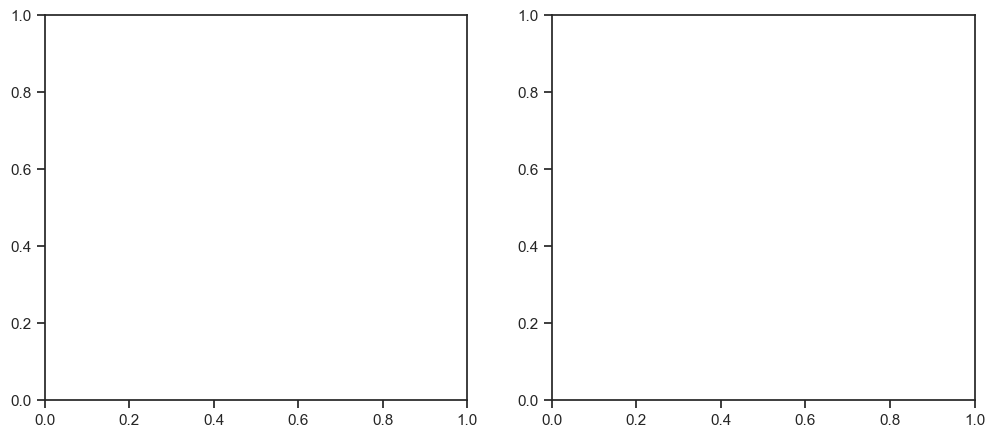

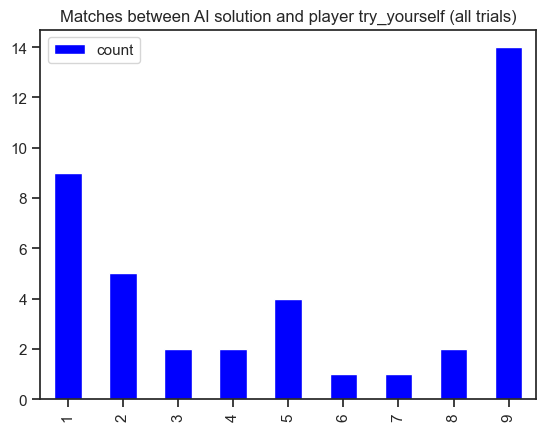

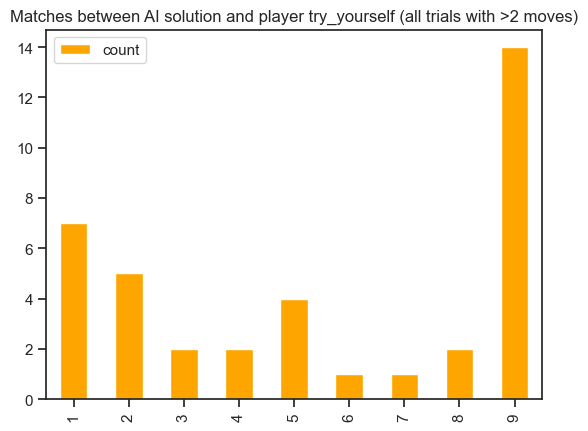

In [121]:
from collections import Counter
from matplotlib.gridspec import GridSpec
df = pd.DataFrame.from_dict(Counter(matches), orient='index', columns=['count'])
df.sort_index(inplace=True)
df2 = pd.DataFrame.from_dict(Counter(matches_excluding), orient='index', columns=['count'])
df2.sort_index(inplace=True)

fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])

ax1=df.plot.bar(color='blue')
ax1.set_title('Matches between AI solution and player try_yourself (all trials)')
ax2=df2.plot.bar(color='orange')
ax2.set_title('Matches between AI solution and player try_yourself (all trials with >2 moves)')
plt.show()

### check 2A performance using only the first 5 trials

In [122]:
q2 = scores_df[(scores_df['expName']=='rn-iii-pilot-2A') &
               (scores_df['trialType']=='individual') &
               (scores_df['trialIdx'].isin([4.0,5.0,6.0,7.0,8.0]))]
q2

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score
211,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,4.0,individual,e3f5160138fcdd6c579c93ea907ec44b,500.0,2.0,1050.0,1050.0
212,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,5.0,individual,c98a5501941cecf8b1bd229a5cfe905b,1200.0,2.0,1250.0,1250.0
213,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,6.0,individual,c2c84d6b0affb2b95b878cd593c191c5,400.0,1.0,1150.0,1150.0
214,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,7.0,individual,1872618c095665e937814bc00c8b2dbb,250.0,1.0,850.0,850.0
215,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,8.0,individual,55c56434f3d6dd1b0b847b0d88b4c0b7,700.0,2.0,1250.0,1250.0
232,63e60e5c86a07638e1044c26,False,rn-iii-pilot-2A,0,4.0,individual,8d353c693eb684f6a3ed4c9fae77de14,-350.0,1.0,1250.0,1250.0
233,63e60e5c86a07638e1044c26,False,rn-iii-pilot-2A,0,5.0,individual,e9f96b22131343106c9be92df71d5f71,800.0,0.0,1250.0,1250.0
234,63e60e5c86a07638e1044c26,False,rn-iii-pilot-2A,0,6.0,individual,e04120a64ec649eb6746d9a62245ce42,600.0,1.0,1050.0,1050.0
235,63e60e5c86a07638e1044c26,False,rn-iii-pilot-2A,0,7.0,individual,ed12667490f18f44f666febe56f74b2c,1250.0,4.0,1450.0,1450.0
236,63e60e5c86a07638e1044c26,False,rn-iii-pilot-2A,0,8.0,individual,70a8b9fb604c3854ad6558966854ec24,200.0,0.0,1250.0,1250.0


In [123]:
scores_dfA = scores_df[(scores_df['expName']=='rn-iii-pilot-2A') &
                       (scores_df['trialType']=='individual') &
                       (scores_df['trialIdx'].isin([4.0,5.0,6.0,7.0,8.0]))]
moves_dfA = pd.read_csv('/Users/bonati/Desktop/CHM/reward_networks/reward-network-iii-analysis/data/final/rn-iii-pilot-2A/moves.csv',index_col=0)
provaA= pd.merge(scores_dfA,moves_dfA, left_on=['sessionId','trialIdx'],right_on=['sessionId','trialID'], how='inner')
provaA

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId_x,score,maxLevelReached,myopic_score,ai_score,trialID,networkId_y,sourceLevel,targetLevel,reward,step,isMissing,matchesMyopic,matchesAI
0,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,4.0,individual,e3f5160138fcdd6c579c93ea907ec44b,500.0,2.0,1050.0,1050.0,4,e3f5160138fcdd6c579c93ea907ec44b,0,0,0,1,False,False,False
1,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,4.0,individual,e3f5160138fcdd6c579c93ea907ec44b,500.0,2.0,1050.0,1050.0,4,e3f5160138fcdd6c579c93ea907ec44b,0,0,200,2,False,False,False
2,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,4.0,individual,e3f5160138fcdd6c579c93ea907ec44b,500.0,2.0,1050.0,1050.0,4,e3f5160138fcdd6c579c93ea907ec44b,0,0,0,3,False,False,False
3,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,4.0,individual,e3f5160138fcdd6c579c93ea907ec44b,500.0,2.0,1050.0,1050.0,4,e3f5160138fcdd6c579c93ea907ec44b,0,0,0,4,False,False,False
4,63e60e5c86a07638e1044c25,False,rn-iii-pilot-2A,0,4.0,individual,e3f5160138fcdd6c579c93ea907ec44b,500.0,2.0,1050.0,1050.0,4,e3f5160138fcdd6c579c93ea907ec44b,0,0,0,5,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,8.0,individual,cce37bd21fb80f3cbaa7b58455355eae,1200.0,2.0,1050.0,1050.0,8,cce37bd21fb80f3cbaa7b58455355eae,1,1,100,4,False,False,False
396,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,8.0,individual,cce37bd21fb80f3cbaa7b58455355eae,1200.0,2.0,1050.0,1050.0,8,cce37bd21fb80f3cbaa7b58455355eae,1,2,-50,5,False,False,False
397,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,8.0,individual,cce37bd21fb80f3cbaa7b58455355eae,1200.0,2.0,1050.0,1050.0,8,cce37bd21fb80f3cbaa7b58455355eae,2,0,400,6,False,False,False
398,63e60e5c86a07638e1044c2e,False,rn-iii-pilot-2A,0,8.0,individual,cce37bd21fb80f3cbaa7b58455355eae,1200.0,2.0,1050.0,1050.0,8,cce37bd21fb80f3cbaa7b58455355eae,0,0,200,7,False,False,False


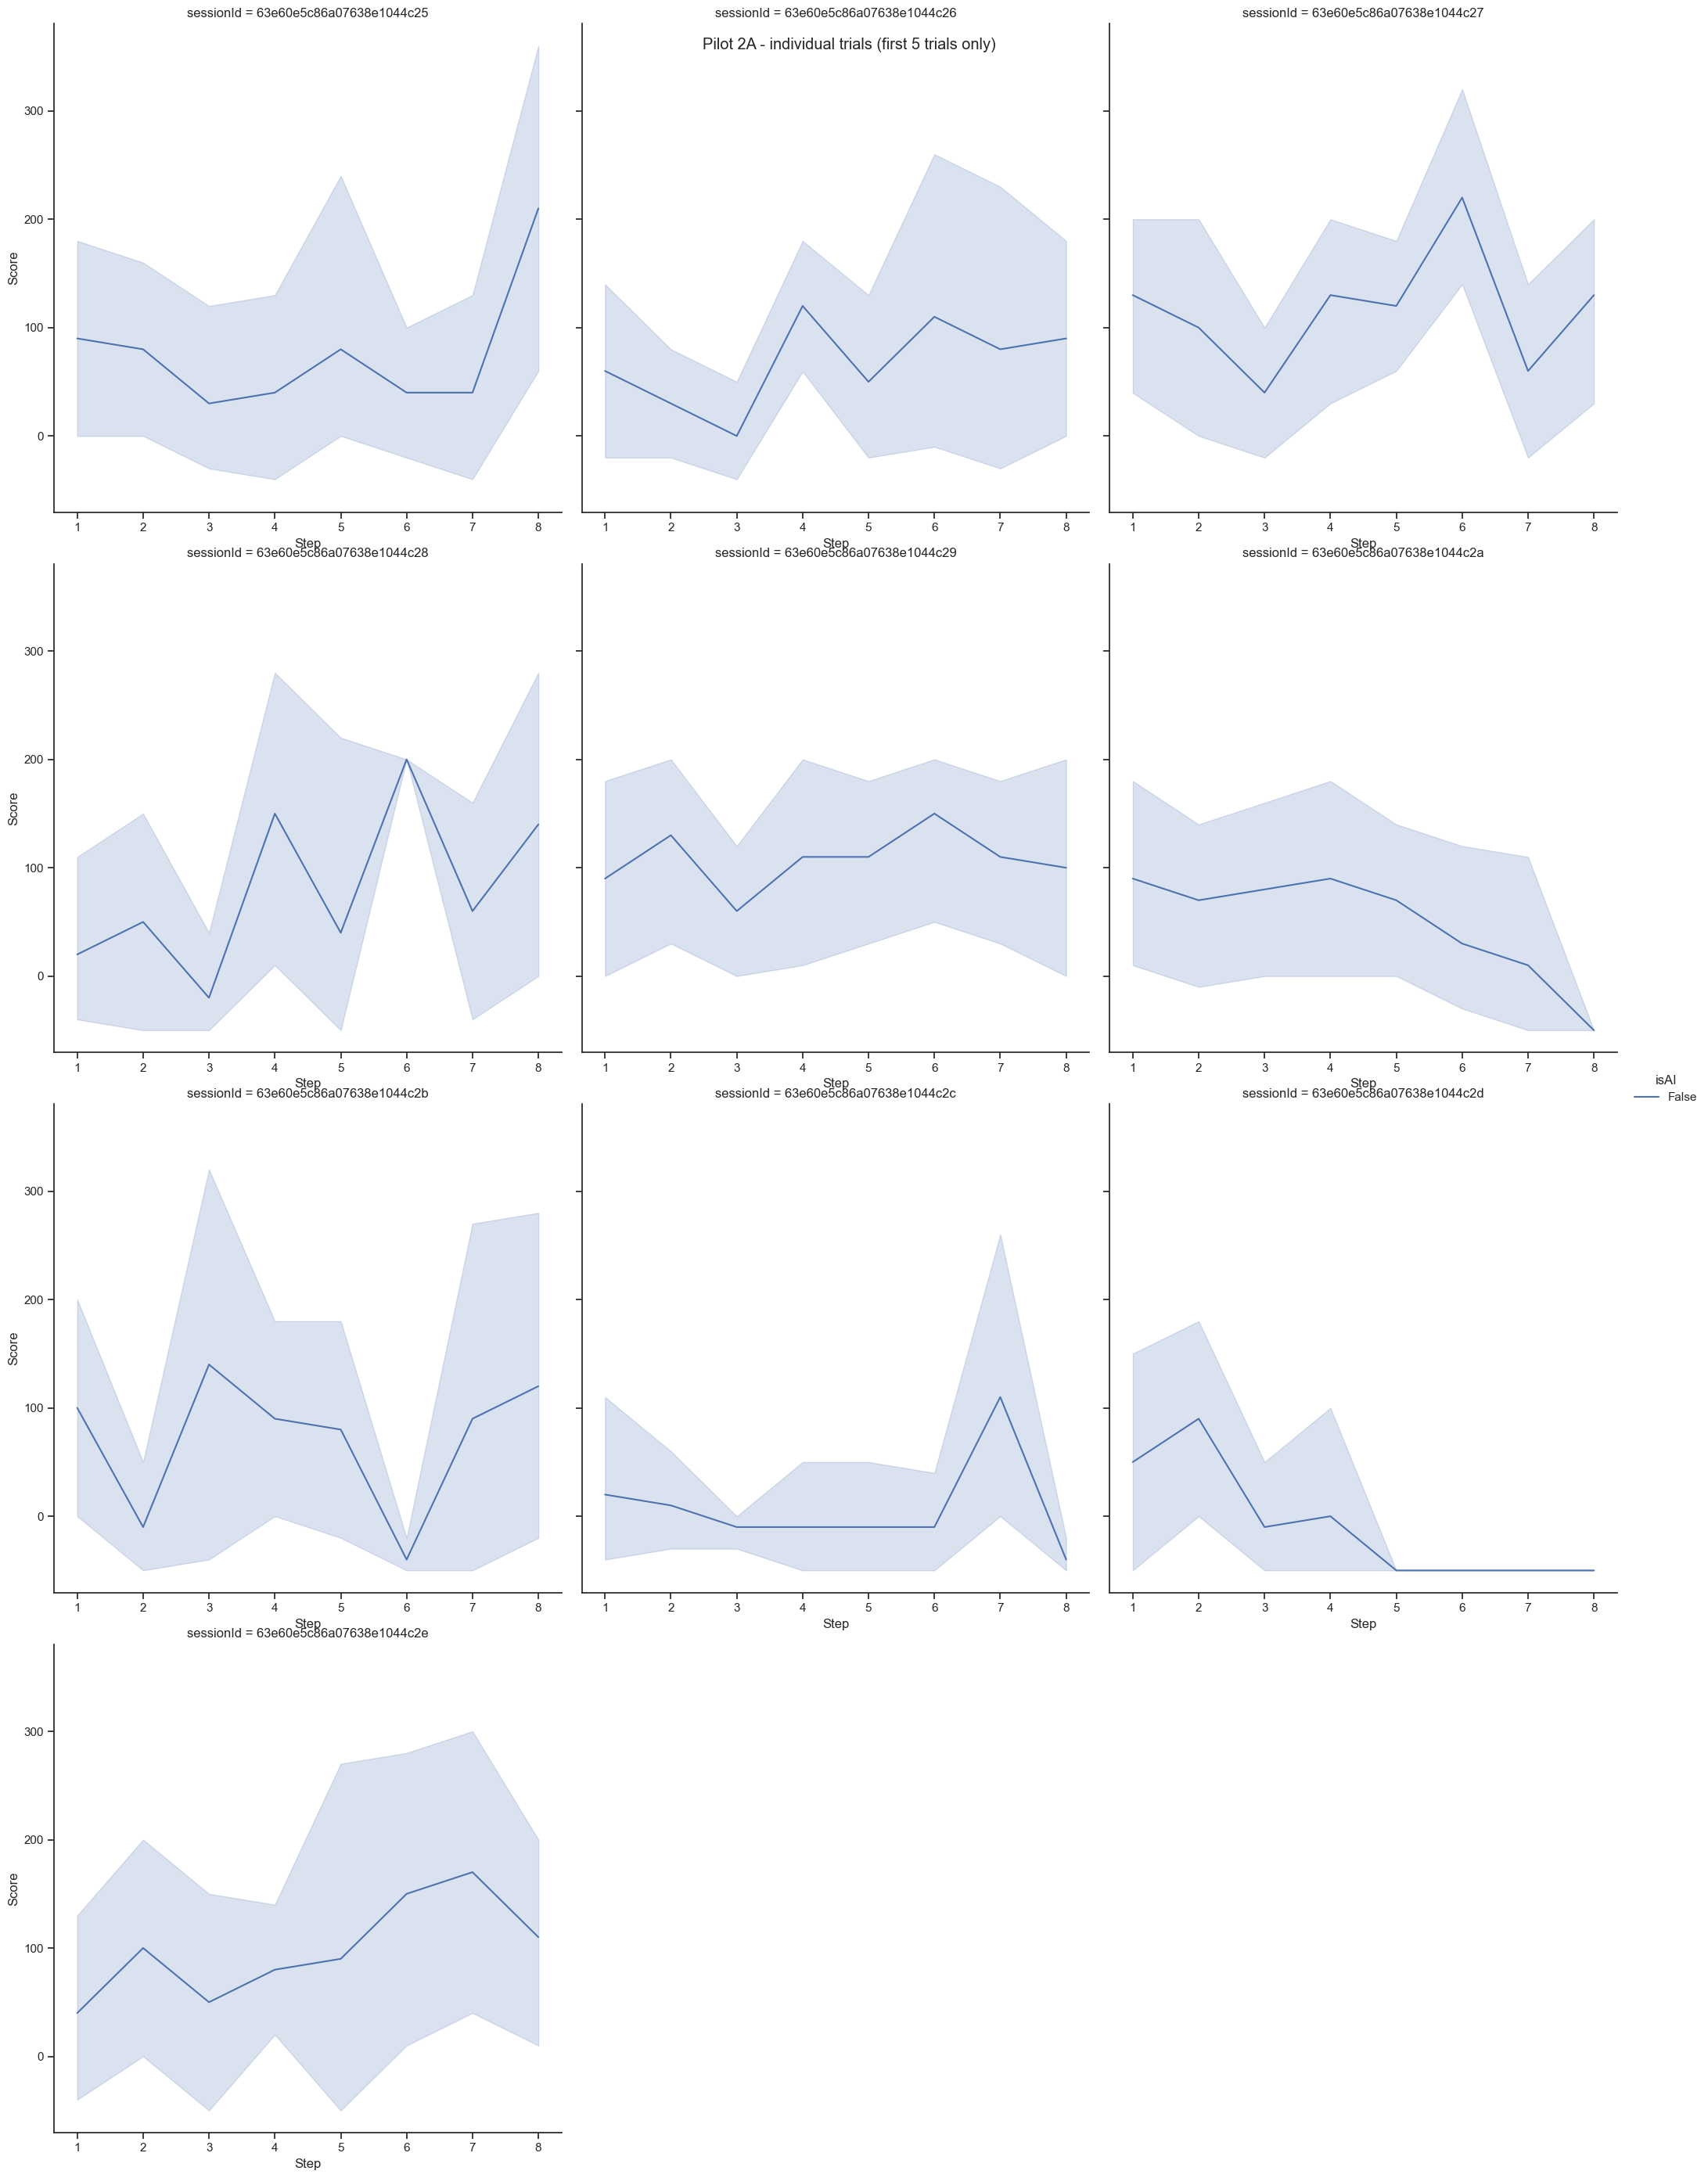

In [124]:
# plot 2A, individual
plot_2A_ind = sns.relplot(data=provaA,
                      x="step",
                      y="reward",
                      hue='isAI',
                      col="sessionId",
                      col_wrap=3,
                      kind="line",
                      errorbar='ci',
                      facet_kws=dict(sharey=True,sharex=False),
                      color='green',
                      height=7,
                      legend='full')
plot_2A_ind.set(xlabel="Step", ylabel="Score")
plot_2A_ind.fig.suptitle("Pilot 2A - individual trials (first 5 trials only)")
# iterate over axes of FacetGrid
for ax in plot_2A_ind.axes.flat:
    ax.set_xticks([i+1 for i in range(8)])
    ax.set_xticklabels([i+1 for i in range(8)])
plot_2A_ind.savefig(os.path.join(figures_path, '2A_5_individual_reward_per_step_participants.pdf'), format='pdf', dpi=300)

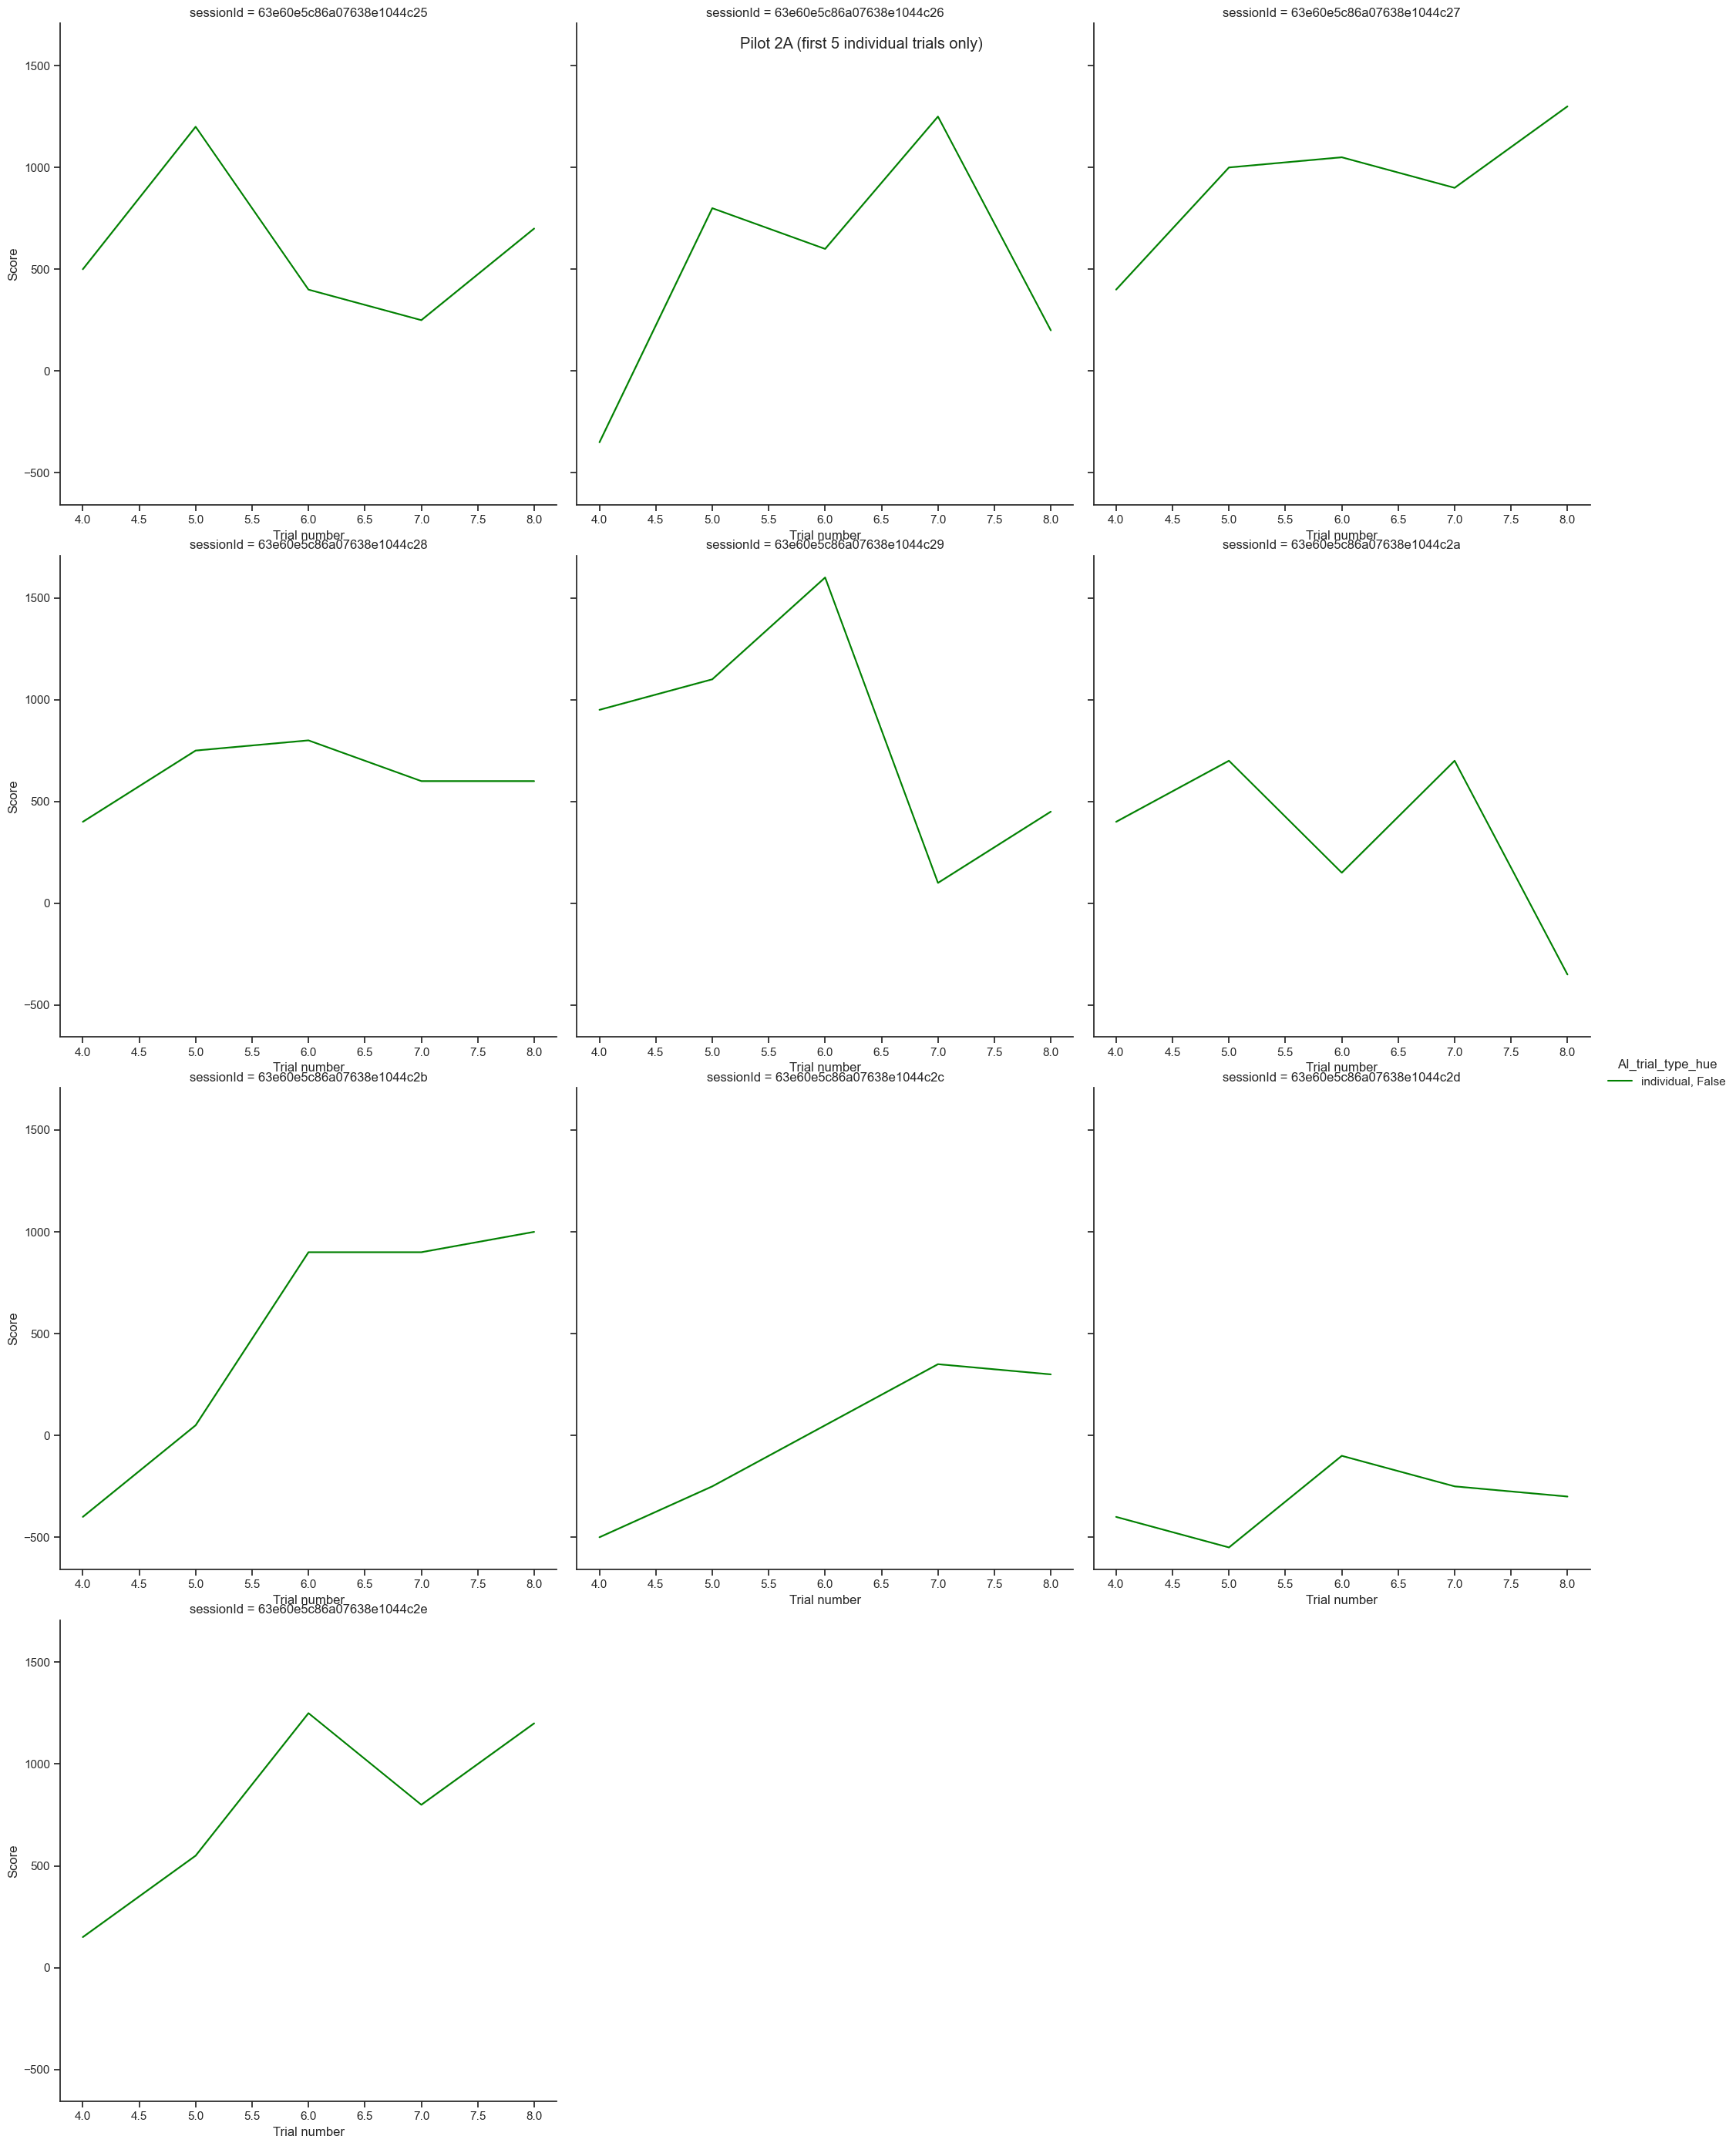

In [125]:
# create plot hue specifically for AI - trial type combo
provaA['AI_trial_type_hue'] = provaA['trialType'].astype(str) + ', ' + provaA['isAI'].astype(str)

fig = sns.relplot(data=provaA,
                      x="trialIdx",
                      y="score",
                      hue='AI_trial_type_hue',
                      col="sessionId",
                      col_wrap=3,
                      kind="line",
                      errorbar='ci',
                      facet_kws=dict(sharey=True,sharex=False),
                      palette={'individual, False':'green'},
                      height=7,
                      legend='full')
fig.set(xlabel="Trial number", ylabel="Score")
fig.fig.suptitle("Pilot 2A (first 5 individual trials only)")
fig.savefig(os.path.join(figures_path, '2A_5_score_over_trialIdx_participants.pdf'), format='pdf', dpi=300)